In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.api as sm
import scipy
from scipy.stats import norm
from scipy.stats.mstats import gmean

from statsmodels.nonparametric.smoothers_lowess import lowess

from numpy.lib.stride_tricks import sliding_window_view

# Load data 

In [3]:
df = pd.read_parquet("/Users/julianeoliveira/Downloads/aesop_2026_01_09_mun.parquet")


In [3]:
lst = ['co_uf','nm_uf','nm_municipio','co_ibge', 'epiyear', 'epiweek','year_week', 'atend_totais', 'atend_ivas','ra_atend_ivas','ra_atend_ivas_ma',]

df = df[lst]

# Functions

In [4]:
# --- helper: smooth MAP curve with LOWESS ---
def smooth_lowess(pr):
    r = np.arange(1, len(pr)+1)
    smoothed = lowess(pr, r, frac=0.3, return_sorted=False)
    return smoothed

In [6]:
# Create season periods

def add_sea(data, year_col="epiyear", week_col="epiweek", n_week=42):
    """
    Add epidemiological season column based on a cutoff week.

    Season definition:
    - weeks >= n_week belong to the next year's season
    - weeks < n_week belong to the current year's season
    The season is labeled by the ending year.
    """

    col = f"season_w{n_week}"

    data[col] = data[year_col]
    data.loc[data[week_col] >= n_week, col] += 1

    return data

In [7]:
def mem_epidemic_period(set_muni, col_year = 'epiyear', col_series = 'atend_ivas_ma',  delta=0.02):
    """
    Compute epidemic period (step 1 of MEM) for each season/year.

    Parameters
    ----------
    set_muni : DataFrame
        Must contain columns ['epiyear', 'atend_ivas'].
    delta : float, optional
        Threshold for slope increment (default=0.02).

    Returns
    -------
    summary : DataFrame
        Columns: ['epiyear', 'r_j_estr', 'k_start', 'k_end']
    details : dict
        Keys = epiyear, values = dict with:
            - r_j_estr : estimated epidemic duration (weeks)
            - k_start  : start week (1-indexed)
            - k_end    : end week (inclusive, 1-indexed)
            - p_j_r    : MAP percentages
            - sm_p_j_r : smoothed MAP curve
            - t_j_r    : cumulative totals by window length
    """
    
    results = {}
    summary_records = []

    for year in sorted(set_muni[col_year].unique()):
        s1 = set_muni[set_muni[col_year] == year].reset_index(drop=True)

        t = np.asarray(s1[col_series])
        S = len(t)
        tS = np.sum(t)

        # --- compute t_j_r (max accumulated per window length) ---
        t_j_r = np.array([
            sliding_window_view(t, r).sum(axis=1).max()
            for r in range(1, S + 1)
        ])

        # --- MAP curve ---
        p_j_r = t_j_r / tS
        sm_p_j_r = smooth_lowess(p_j_r)

        # --- increments Δr ---
        delta_j_r = np.diff(sm_p_j_r)

        # --- determine optimal duration r_j_estr ---
        indices = np.where(delta_j_r < delta)[0]
        r_j_estr = int(indices.min()) if len(indices) > 0 else S

        # --- find k_estr (start index of epidemic window) ---
        window_r = sliding_window_view(t, r_j_estr)
        window_sums = window_r.sum(axis=1)
        k_estr = window_sums.argmax()

        k_start = k_estr + 1          # 1-indexed
        k_end   = k_estr + r_j_estr   # inclusive

        # --- save results ---
        results[year] = {
            'r_j_estr': r_j_estr,
            'k_start': k_start,
            'k_end': k_end,
            'p_j_r': p_j_r,
            'sm_p_j_r': sm_p_j_r,
            't_j_r': t_j_r
        }

        summary_records.append({
            'epiyear': year,
            'r_j_estr': r_j_estr,
            'k_start': k_start,
            'k_end': k_end
        })

    summary = pd.DataFrame(summary_records)

    return summary, results


# Applying the method to data

In [8]:
df = add_sea(df)

In [ ]:
#df = df[df.year_week >= '2021-42'].copy()

In [56]:
set_muni = df[df.co_ibge == 210120]

set_muni = set_muni.assign(atend_ivas_ma = set_muni["atend_ivas"].rolling(window=4, min_periods=1).mean(),
                           atend_ivas_ma8 = set_muni["atend_ivas"].rolling(window=8, min_periods=1).mean(),
                           ra_atend_ivas_ma2 = set_muni['ra_atend_ivas'].rolling(window=4, min_periods=1).mean())



In [57]:
summary, details = mem_epidemic_period(set_muni,col_year = 'season_w42', col_series = 'atend_ivas_ma', delta=0.02)

In [58]:
summary

,epiyear,r_j_estr,k_start,k_end
0,2017,24,18,41
1,2018,10,29,38
2,2019,9,13,21
3,2020,17,33,49
4,2021,7,19,25
5,2022,0,1,0
6,2023,8,5,12
7,2024,8,22,29
8,2025,18,26,43
9,2026,7,6,12


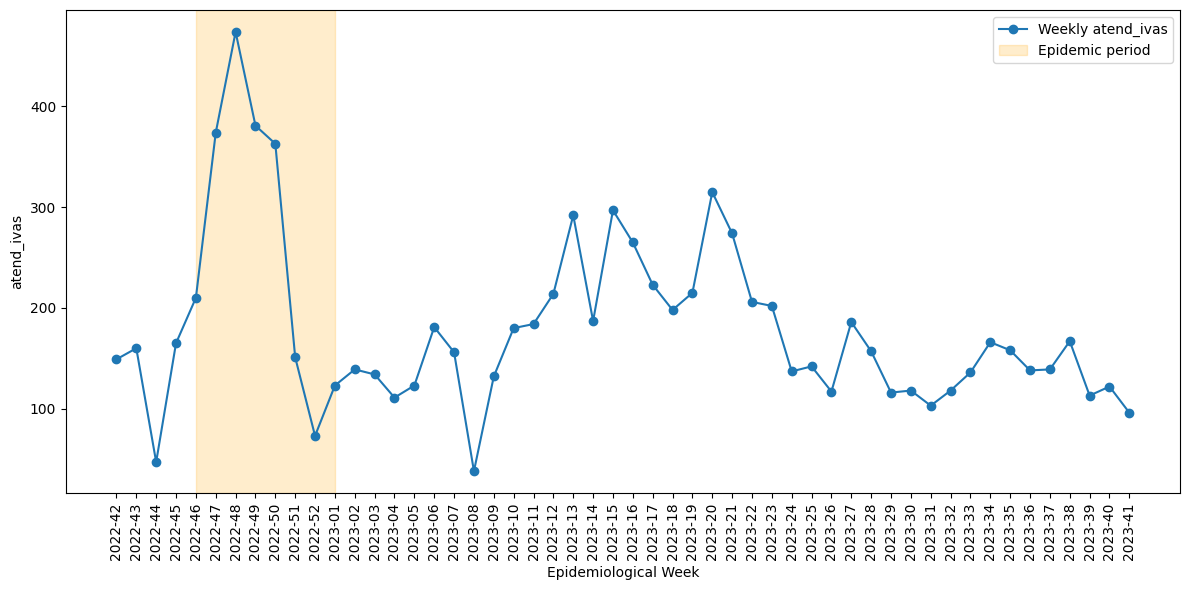

In [59]:
fig, ax = plt.subplots(figsize=(12,6))

year = 2023
#'season_w42' # epiyear

season = set_muni[set_muni['season_w42'] == year].reset_index()

k_s = summary[summary['epiyear'] == year].k_start.max()

k_e = summary[summary['epiyear'] == year].k_end.max()
        
# plot weekly values
#ax.plot(season["year_week"], season['atend_ivas'], marker="o", label="Weekly atend_ivas")
ax.plot(season["year_week"], season['atend_ivas'], marker="o", label="Weekly atend_ivas")
        
# highlight epidemic window
ax.axvspan(season.loc[k_s-1, "year_week"], season.loc[k_e-1, "year_week"], 
                   color="orange", alpha=0.2, label="Epidemic period")
        
        
# labels
plt.xticks(rotation=90)
ax.set_xlabel("Epidemiological Week")
ax.set_ylabel("atend_ivas")
ax.legend()
plt.tight_layout()
plt.show()

#  Baseline and Epidemic threshold

In [20]:
def baseline_thresholds(
    dta,
    lst_sea,
    value_col="atend_ivas",
    col_year="epiyear",
    col_week="epiweek",
    delta=0.02,
):
    """
    Compute baselines and epidemic thresholds from seasonal surveillance data.
    
    Parameters
    ----------
    dta : pd.DataFrame
        Full dataset containing at least columns: ["epiyear", "epiweek", value_col].
    lst_sea : list
        List of epidemic years to include in the calculation.
    value_col : str
        Column name with weekly counts (default = 'atend_ivas').
    
    Returns
    -------
        - baseline
        - post_baseline
        - epidemic_threshold
        - post_threshold
        - df_thresholds_intensity (DataFrame with 50%, 90%, 95% thresholds)
    """

    pre_values, post_values, epi_values = [], [], []
    pre_top, post_top, epi_top = [], [], []

    n = max(1, round(30 / len(lst_sea)))

    for year in lst_sea:
        season = dta[dta[col_year] == year]
        if season.empty:
            continue

        summary, details = mem_epidemic_period(dta, col_year = col_year, col_series = 'atend_ivas_ma', delta=0.02)
        
        k_s = int(summary.loc[summary[col_year] == year, "k_start"].iloc[0])
        k_e = int(summary.loc[summary[col_year] == year, "k_end"].iloc[0])

        pre = season.loc[season[col_week] <= k_s, value_col].values
        post = season.loc[season[col_week] > k_e, value_col].values
        epi = season.loc[
            (season[col_week] > k_s) & (season[col_week] <= k_e),
            value_col,
        ].values

        pre_values.extend(pre)
        post_values.extend(post)
        epi_values.extend(epi)

        pre_top.extend(sorted(pre, reverse=True)[:n])
        post_top.extend(sorted(post, reverse=True)[:n])
        epi_top.extend(sorted(epi, reverse=True)[:n])

    pre_values, post_values, epi_values = map(np.array, [pre_values, post_values, epi_values])
    pre_top, post_top, epi_top = map(np.array, [pre_top, post_top, epi_top])

    baseline = np.mean(pre_values)
    post_baseline = np.mean(post_values)

    z = norm.ppf(0.95)

    epidemic_threshold = np.mean(pre_top) + z * np.std(pre_top, ddof=1)
    post_threshold = np.mean(post_top) + z * np.std(post_top, ddof=1)

    epi_top = epi_top[epi_top > 0]
    log_vals = np.log(epi_top)

    thresholds_intensity = {
        f"{int(p*100)}%": np.exp(np.mean(log_vals) + norm.ppf(p) * np.std(log_vals, ddof=1))
        for p in [0.50, 0.90, 0.95]
    }

    df_thresholds_intensity = pd.DataFrame(
        thresholds_intensity.items(), columns=["percentile", "value"]
    )

    return {
    "baseline": baseline,
    "post_baseline": post_baseline,
    "epidemic_threshold": epidemic_threshold,
    "post_threshold": post_threshold,
    "intensity": df_thresholds_intensity,
}

    

In [21]:
lst_sea = [ 2022, 2023, 2024] #2020, 2021

In [22]:
set_muni

,co_uf,nm_uf,nm_municipio,co_ibge,epiyear,epiweek,year_week,atend_totais,atend_ivas,ra_atend_ivas,ra_atend_ivas_ma,season_w42,atend_ivas_ma,ra_atend_ivas_ma2
261,11,Rondônia,Alta Floresta D'Oeste,110001,2022,1,2022-01,281,38,13.52,12.72,2022,44.25,12.7150
262,11,Rondônia,Alta Floresta D'Oeste,110001,2022,2,2022-02,853,109,12.78,13.28,2022,56.75,13.2800
263,11,Rondônia,Alta Floresta D'Oeste,110001,2022,3,2022-03,563,28,4.97,11.42,2022,48.25,11.4175
264,11,Rondônia,Alta Floresta D'Oeste,110001,2022,4,2022-04,435,23,5.29,9.14,2022,49.50,9.1400
265,11,Rondônia,Alta Floresta D'Oeste,110001,2022,5,2022-05,458,28,6.11,7.29,2022,47.00,7.2875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,11,Rondônia,Alta Floresta D'Oeste,110001,2025,49,2025-49,806,27,3.35,1.96,2026,14.25,1.9575
466,11,Rondônia,Alta Floresta D'Oeste,110001,2025,50,2025-50,639,12,1.88,2.30,2026,16.75,2.3000
467,11,Rondônia,Alta Floresta D'Oeste,110001,2025,51,2025-51,1006,21,2.09,2.41,2026,19.75,2.4100
468,11,Rondônia,Alta Floresta D'Oeste,110001,2025,52,2025-52,206,6,2.91,2.56,2026,16.50,2.5575


In [23]:
res = baseline_thresholds(
    set_muni,
    lst_sea=lst_sea,
    value_col="atend_ivas",
    col_year = 'season_w42',
    col_week="epiweek",
)

KeyError: 'season_w42'

In [110]:
baseline

32.833333333333336

In [111]:
epidemic_threshold

60.83052599136815

In [112]:
df_thresholds_intensity

,percentile,value
0,50%,30.862924
1,90%,57.644082
2,95%,68.812845


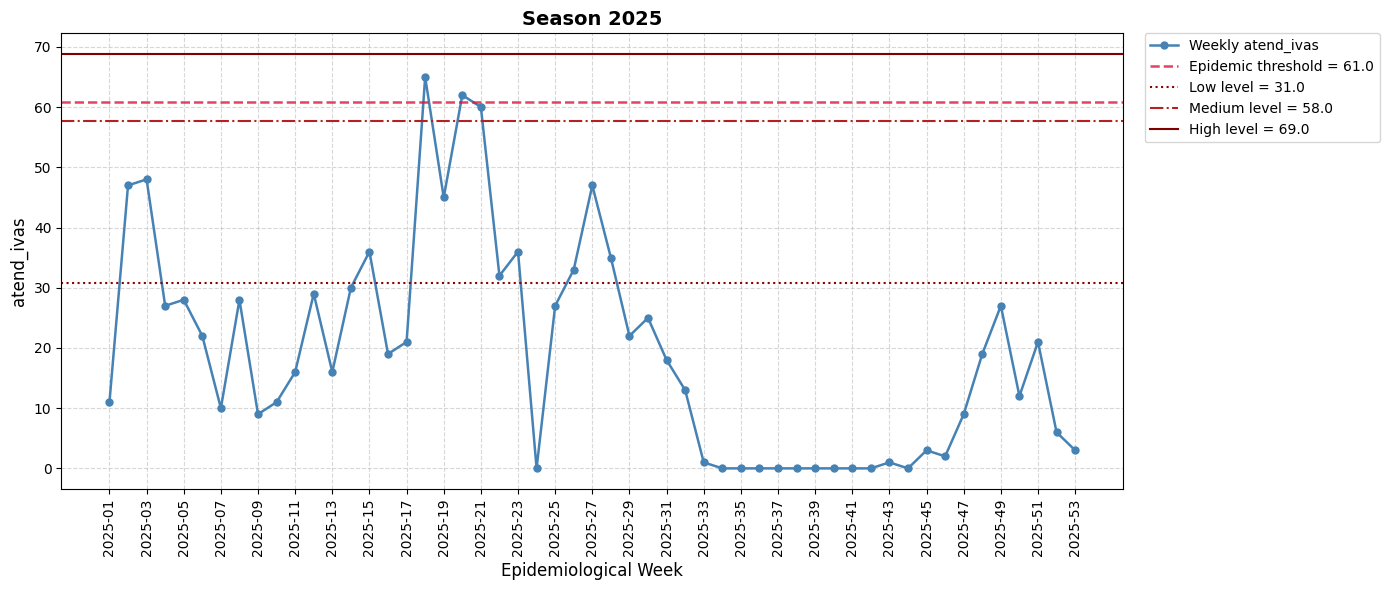

In [113]:
fig, ax = plt.subplots(figsize=(14,6))

year = 2025

# subset the season data
season = set_muni[set_muni.epiyear == year].reset_index(drop=True)

# get start and end from summary
k_s = int(summary.loc[summary.epiyear == year, "k_start"].iloc[0])
k_e = int(summary.loc[summary.epiyear == year, "k_end"].iloc[0])

# plot weekly values
ax.plot(season["year_week"], season['atend_ivas'], 
        marker="o", markersize=5, linewidth=1.8, color="steelblue", 
        label="Weekly atend_ivas")

# thresholds
ax.axhline(epidemic_threshold, color="crimson", alpha=0.8, linestyle="--", linewidth=1.8,
           label=f"Epidemic threshold = {round(epidemic_threshold,0)}")

ax.axhline(df_thresholds_intensity.value.iloc[0], color="darkred", linestyle=":", linewidth=1.5,
           label=f"Low level = {round(df_thresholds_intensity.value.iloc[0],0)}")
ax.axhline(df_thresholds_intensity.value.iloc[1], color="firebrick", linestyle="-.", linewidth=1.5,
           label=f"Medium level = {round(df_thresholds_intensity.value.iloc[1],0)}")
ax.axhline(df_thresholds_intensity.value.iloc[2], color="maroon", linestyle="-", linewidth=1.5,
           label=f"High level = {round(df_thresholds_intensity.value.iloc[2],0)}")

# labels & formatting
ax.set_xlabel("Epidemiological Week", fontsize=12)
ax.set_ylabel("atend_ivas", fontsize=12)
ax.set_title(f"Season {year}", fontsize=14, fontweight="bold")

# x-axis ticks (reduce clutter)
ax.set_xticks(season["year_week"][::2])  # every 2 weeks
ax.set_xticklabels(season["year_week"][::2], rotation=90)

# grid
ax.grid(True, linestyle="--", alpha=0.5)

# legend outside
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
plt.show()
